In [1]:

""" 
Calculating how self-avoiding walks fluctuate in different temperatures.
For some temperature beta (in Kelvins), how will the average number of interactions of some system of size n change?
"""

import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read in number of configurations, C(n,m), in a system of size n with precisely m nearest neighbour interactions

def GetConfigurationCounts(n: int, dataFilename: str):
    """ Return an array where arr[m] contains C(n,m) """
    configurationCounts = np.zeros(n+2)
    with open(dataFilename, 'r') as f:
        f_content = [line.split() for line in f.readlines()]
        
        match dataFilename:
            case '../data/cactus/cactus_saw_counts.ser':
                # Extrapolate all lines enumerating n step configurations
                nStepConfigurations = [line for line in f_content if line[0] == str(n)]
                # Clean up remaining lines by casting to ints
                nStepConfigurations = [list(map(lambda x: int(x), line)) for line in nStepConfigurations] 
                # Assign the data given the extrapolated counts
                for line in nStepConfigurations:
                    configurationCounts[line[1]] = line[2]
            case '../data/interacting/interacting_saw_counts.ser':
                nStepConfigurations = [line for line in f_content if line[1] == str(n)]
                nStepConfigurations = [list(map(lambda x: int(x), line)) for line in nStepConfigurations] 
                for line in nStepConfigurations:
                    configurationCounts[line[0]] = line[2]
            case '../data/interacting/interacting_saw_best_est.ser':
                nStepConfigurations = list(map(lambda x: float(x), f_content[n]))
                return nStepConfigurations
            case '../data/cactus/cactus_saw_best_est.ser':
                nStepConfigurations = list(map(lambda x: float(x), f_content[n]))
                return nStepConfigurations
    
    # Remove trailing zeros
    configurationCounts = configurationCounts[configurationCounts != 0]
    return configurationCounts

print(GetConfigurationCounts(10, '../data/interacting/interacting_saw_counts.ser'))
print(GetConfigurationCounts(10, '../data/cactus/cactus_saw_counts.ser'))

def Z(C, beta: float) -> float:
    total = 0
    for m in range(len(C)):
        total += C[m] * math.exp(beta * m)
    return total

def ProbabilityDistribution(m: int, beta: float, C) -> float:
    return (1 / Z(C, beta)) * C[m] * math.exp(beta * m)

def EvaluateVariances(N: int, temperatures, dataFilename: str):
    """ 
    Calculate the variance [E[x^2]-E[x]^2] given a system size and number of temperature sample.
    Returns a 2D array, variance, where variance[N][T] is the variance of system of size N at temperature T.
    """

    variance = np.zeros((N+1, len(temperatures)))
    for n in range(1, N+1):
        for idx,temp in enumerate(temperatures):
            C = GetConfigurationCounts(n, dataFilename)
            x_0 = list(map(lambda m: ProbabilityDistribution(m, temp, C) * m, range(len(C))))
            x_1 = list(map(lambda m: ProbabilityDistribution(m, temp, C) * m * m, range(len(C))))
            
            expected_X  = sum(x_0)
            expected_X2 = sum(x_1)

            # Normalized variance (fluctuations)
            variance[n][idx] = (expected_X2 - (expected_X * expected_X)) / n

    return variance

[12668. 14224.  9832.  4608.  2384.   384.]
[4.41000000e+04 9.40064000e+05 8.94077200e+06 5.00359120e+07
 1.82892528e+08 4.57972064e+08 8.00772432e+08 9.76667008e+08
 8.13510712e+08 4.40393152e+08 1.39388704e+08 1.95429440e+07]


In [3]:
def PlotCounts(subplot, N: int, temperatures, dataFilename: str, colour: str) -> None:
    variances = EvaluateVariances(N, temperatures, dataFilename)

    for n in reversed(range(N+1)):
        subplot.plot(temperatures, [n for _ in range(len(temperatures))], variances[n][:], colour)
    
    subplot.set_xlabel('X : Temperature')
    subplot.set_ylabel('Y : System Size')
    subplot.set_zlabel('Z : Variance')

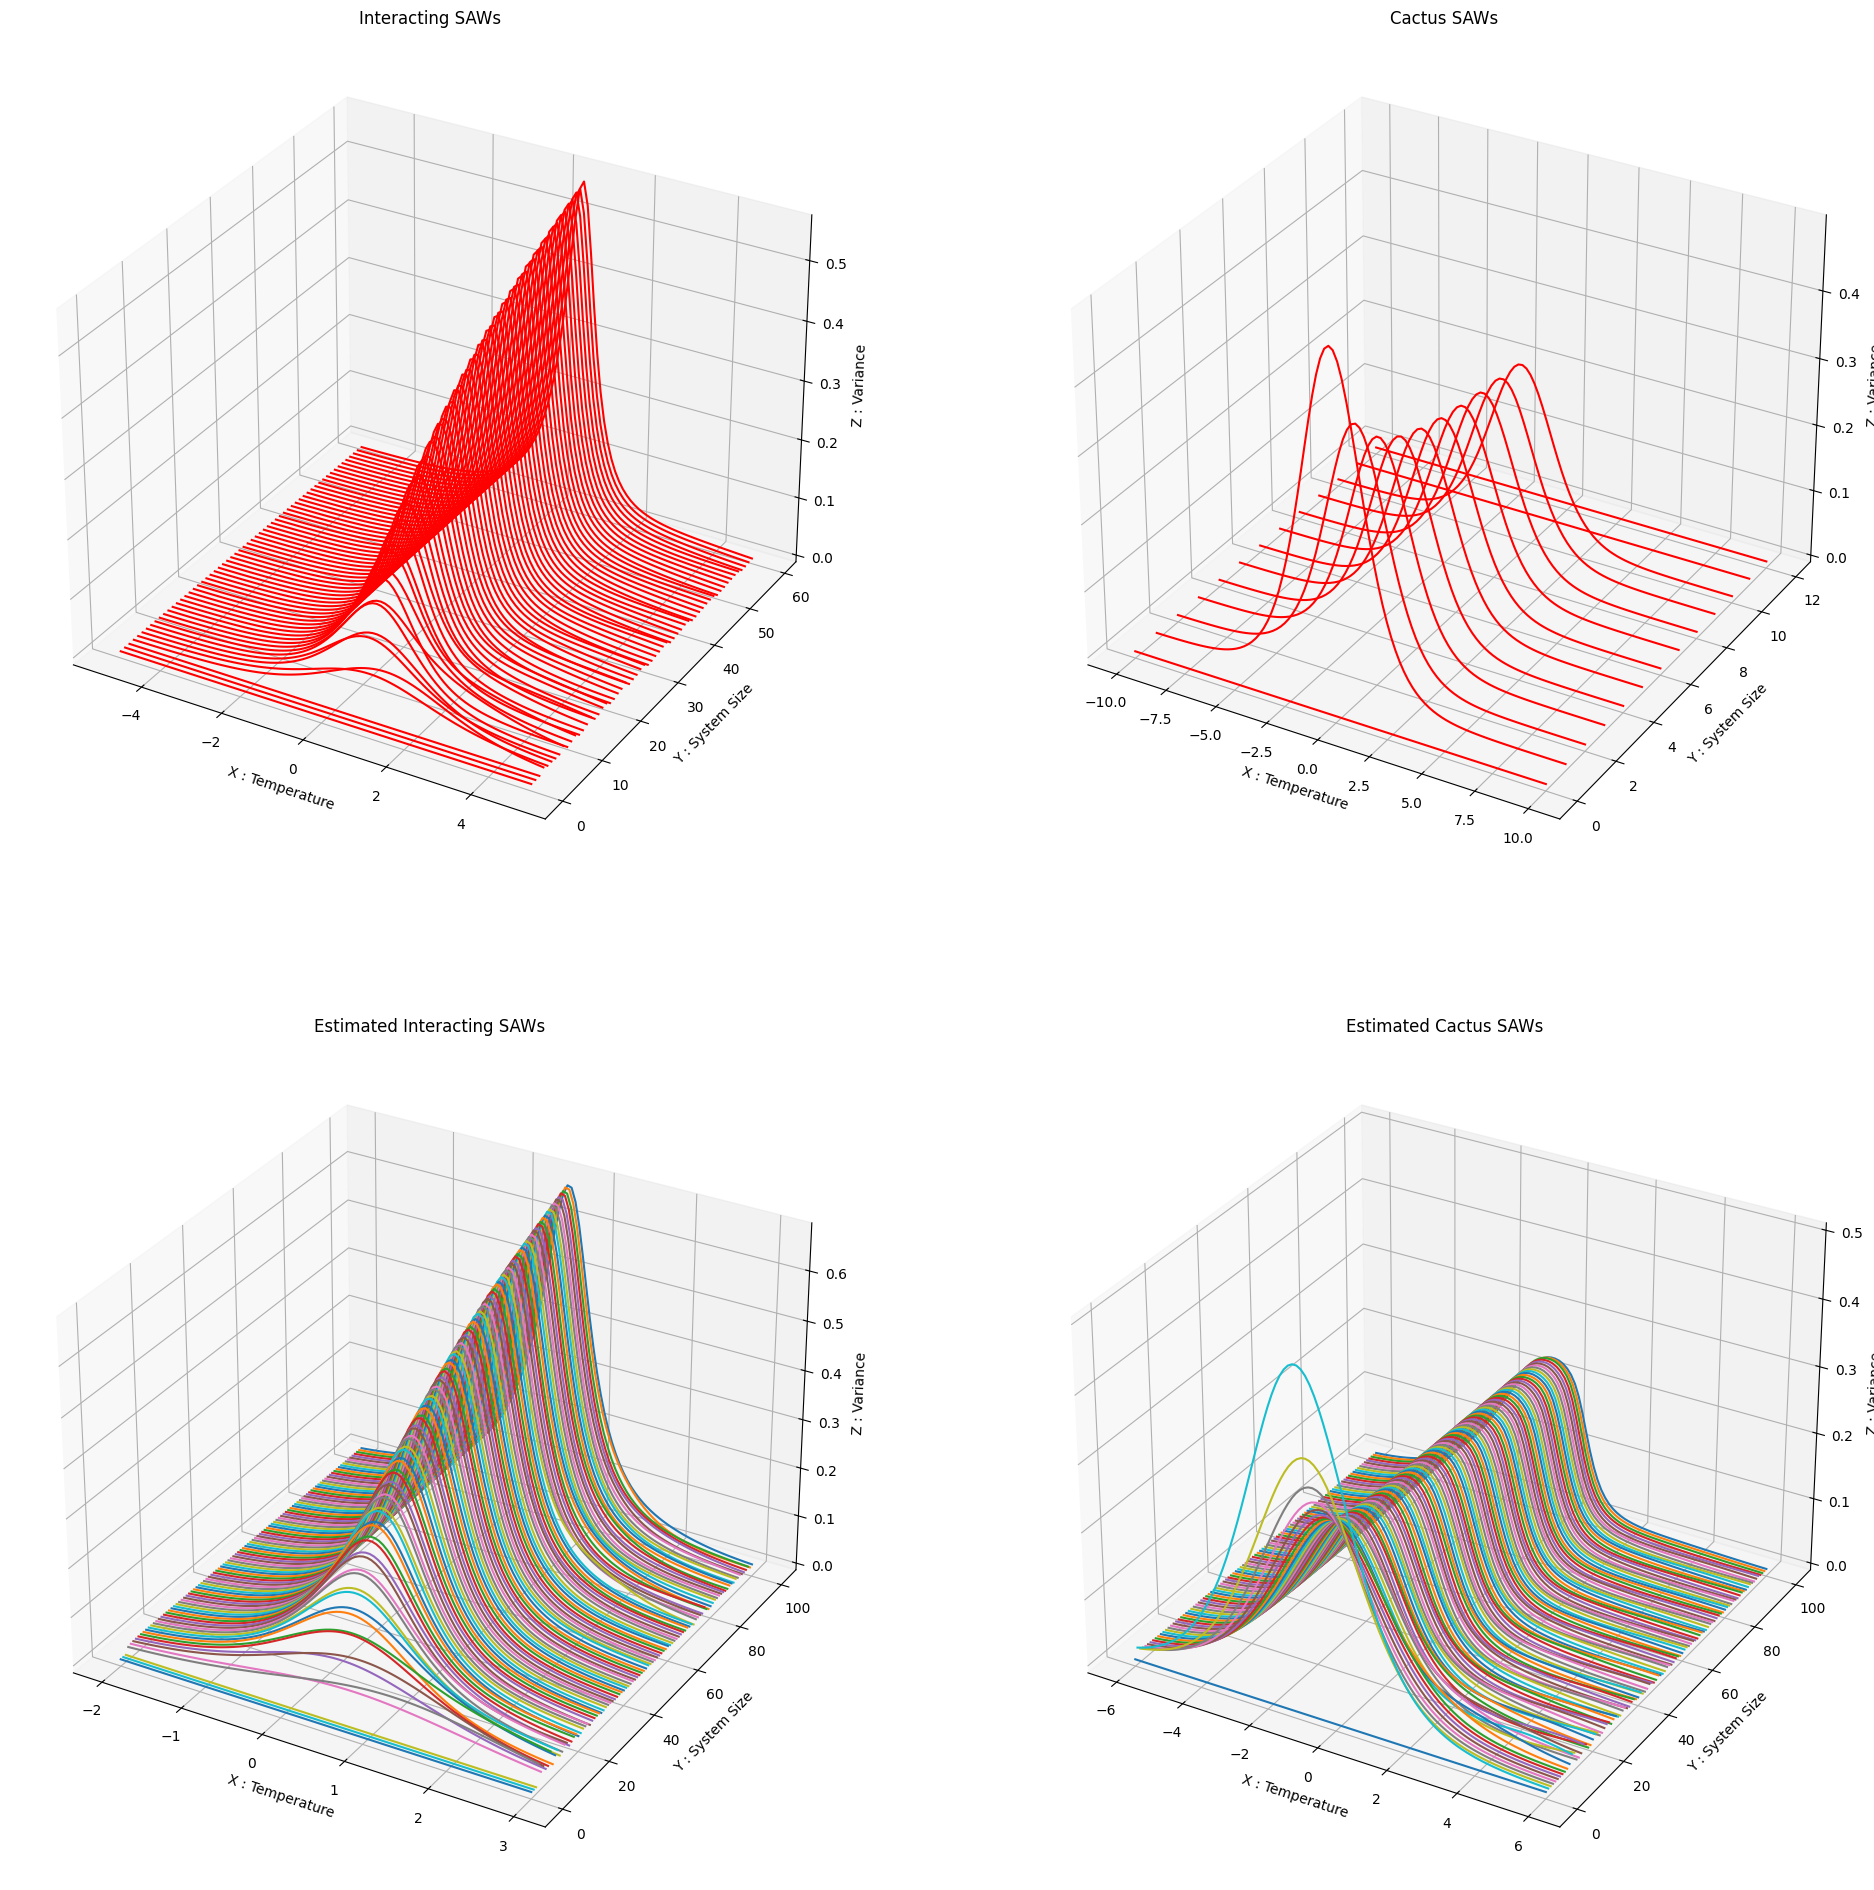

In [4]:
plt.rcParams.update({'font.serif': 'Times New Roman',
                     'font.size': 10.0,
                     'axes.labelsize': 'Medium',
                     'axes.labelweight': 'normal',
                     'axes.linewidth': 0.8,
                     'figure.figsize':[15,15] })

fig = plt.figure(figsize=(24,24))
ax_interactions  = fig.add_subplot(2,2,1, projection='3d')
ax_cactus        = fig.add_subplot(2,2,2, projection='3d')


## Data Filenames
#
exact_interacting   = '../data/interacting/interacting_saw_counts.ser'
exact_cactus        = '../data/cactus/cactus_saw_counts.ser'

est_interacting     = '../data/interacting/interacting_saw_best_est.ser'
est_cactus          = '../data/cactus/cactus_saw_best_est.ser'

### Interacting SAW Exact Counts ###
# Set system properties e.g Size, Temp...
N = 59
temperatures = np.linspace(-5, 5, 100)
PlotCounts(ax_interactions, N, temperatures, exact_interacting, 'r')
ax_interactions.set_title('Interacting SAWs')


### Cactus SAW Exact Counts ###
# Set system properties e.g Size, Temp...
N = 12
temperatures = np.linspace(-10, 10, 100)
PlotCounts(ax_cactus, N, temperatures, exact_cactus, 'r')
ax_cactus.set_title('Cactus SAWs')


ax_estimatedInteractions = fig.add_subplot(2,2,3, projection='3d')
ax_estimatedCactus       = fig.add_subplot(2,2,4, projection='3d')

### Estimated Interacting SAW Exact Counts
# Set system properties e.g Size, Temp...
with open(est_interacting,'r') as f:
    N = len(f.readlines()) - 1
temperatures = np.linspace(-2, 3, 100)
PlotCounts(ax_estimatedInteractions, N, temperatures, est_interacting, '')
ax_estimatedInteractions.set_title('Estimated Interacting SAWs')

### Estimated Cactus SAW Exact Counts
# Set system properties e.g Size, Temp...
with open(est_cactus,'r') as f:
    N = len(f.readlines()) - 1
temperatures = np.linspace(-6, 6, 100)
PlotCounts(ax_estimatedCactus, N, temperatures, est_cactus, '')
ax_estimatedCactus.set_title('Estimated Cactus SAWs')

plt.show()
